# Model

In [49]:
from mininlp.transformer import DTransformer
import json
from mininlp.data import Tokenizer, SequenceDataset
import os
import torch


VERSION = '0.1.1'
MODEL_NAME = f'decoder_transformer_v{VERSION}'
config = json.load(open(f"../models/{MODEL_NAME}.json"))

tokenizer = Tokenizer()
tokenizer.load(os.path.join('../models', 'tokenizer.pkl'))

model = DTransformer(
    config['layers'], 
    config['embedding_dim'], 
    len(tokenizer), 
    config['seq_len'], 
    config['heads'], 
    config['factor'],
    True)
model = torch.compile(model)
state_dict = torch.load(f"../models/{MODEL_NAME}.pt")
model.load_state_dict(state_dict)
model.to('cuda')

OptimizedModule(
  (_orig_mod): DTransformer(
    (_embedding): Embedding(
      (_token_embedding): Embedding(105, 256)
    )
    (_decoders): ModuleList(
      (0-15): 16 x Decoder(
        (_laynorm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (_laynorm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (_mmha): MultiHeadAttention(
          (_projection): ModuleList(
            (0-2): 3 x Linear(in_features=256, out_features=256, bias=True)
          )
          (_reprojection): Linear(in_features=256, out_features=256, bias=True)
        )
        (_mha): MultiHeadAttention(
          (_projection): ModuleList(
            (0-2): 3 x Linear(in_features=256, out_features=256, bias=True)
          )
          (_reprojection): Linear(in_features=256, out_features=256, bias=True)
        )
        (_ff): FeedForward(
          (_laynorm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (_dropout): Dropout(p=0.2, inplace=False)
       

In [50]:
tokenizer = Tokenizer()
tokenizer.load("../models/tokenizer.pkl")
dataset = SequenceDataset('../data/anna.txt', tokenizer, config['seq_len'], 1)

import torch.nn.functional as F
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    input = dataset[0][0].unsqueeze(0)
    output = model(input.to('cuda'))
    probs = F.softmax(output[0, -1, :], dim=0)
    probs = probs.detach().cpu()
    
plt.figure(figsize=(20, 5))
plt.bar(tokenizer.decode(torch.tensor(range(len(probs)))), probs)
plt.xticks(rotation=90)
plt.show()

In [51]:
text = tokenizer.decode(dataset[0][0])
text += ["<msk>"]
model.eval()
with torch.no_grad():
    prompt = dataset[0][0].unsqueeze(0).to('cuda')
    text += tokenizer.decode(model.generate(prompt, 500))

In [52]:
text = [t for t in text if t != "<pad>"]
print("".join(text))

lid guards the eye, and without the key of love he let no one into
his soul. His teachers complained that he would not learn, while his
soul was brimming over with thirst for knowledge. And he learned from
Kapitonitch, from his nurse, from Nadinka, from Vassily Lukitch, but not
from his teachers. The spring his father and his teachers reckoned upon
to turn their mill-wheels had long dried up at the source, but its
waters did their work in another channel.

His father punished Seryozha by not letting him go <msk>her. No the
wenting of and her stort. She was all not at the man geest feeling-be over an for
a modeth, which he had had they come over he quickly soft the recover had
Karned to much to natural and reading gentled certain his him whitelizal
Kitty that he has had been come senting and to Not intensity making
his dog better. The countess of the first that the lart what this
brick always about previples, and even too say the day ached which had not was
come. Worn certained the sham

In [53]:
arr = [4, 6, 8, 10, 12, 14, 16, 18, 20]
arr[5:40]

[14, 16, 18, 20]

### Gradient Accumulation

In [54]:
import torch 
import torch.nn.functional as F

data = torch.tensor([4.0, 6, 8, 10, 12, 14, 16, 18, 20]).reshape(3,-1)
labels = torch.tensor([10.0, 20, 30]).reshape(3,-1)

In [55]:
model = torch.nn.Linear(3, 1)
model(data)

tensor([[1.2102],
        [2.0578],
        [2.9054]], grad_fn=<AddmmBackward0>)

Non gradient accumulation

In [56]:
loss = F.mse_loss(model(data), labels)
loss.backward()
model.weight.grad, model.bias.grad

(tensor([[-432.0627, -503.8314, -575.6000]]), tensor([-35.8843]))

Gradient accumulation

In [57]:
i = 0
model.weight.grad = torch.zeros_like(model.weight.grad)
model.bias.grad = torch.zeros_like(model.bias.grad)
model.weight.grad, model.bias.grad

(tensor([[0., 0., 0.]]), tensor([0.]))

In [58]:
loss = F.mse_loss(model(data[i,]), labels[i,]) / 3
loss.backward()
i += 1
model.weight.grad, model.bias.grad

(tensor([[-23.4394, -35.1590, -46.8787]]), tensor([-5.8598]))

### Learning Rate Scheduler

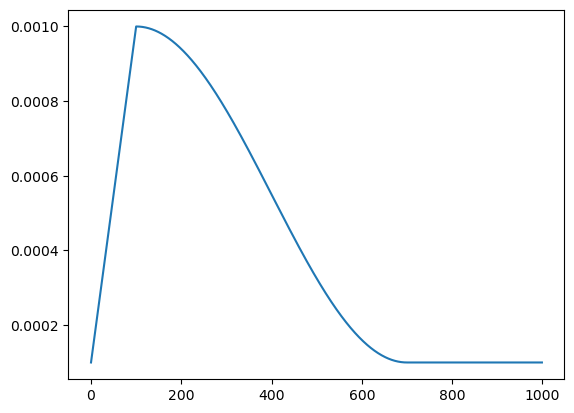

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def lr_schedule(max_lr, min_lr, n_batchs, batch, pct_start=0.1, pct_bottom=0.7):
    # cosine learning rate
    warmup_step = torch.tensor(pct_start * n_batchs)
    bottom_step = torch.tensor(pct_bottom * n_batchs)
    if batch < warmup_step:
        return (max_lr - min_lr) / warmup_step * batch + min_lr
    elif batch < bottom_step:
        # some calculus to scale and shift the cosine function
        return (max_lr - min_lr) / 2 * torch.cos(torch.pi / (bottom_step - warmup_step) * (batch - warmup_step)) + (max_lr + min_lr) / 2 
    else:
        return min_lr

n_data = 1000
max_lr = 0.001
min_lr = 0.0001
batch = np.arange(0, n_data)
lr = torch.tensor([lr_schedule(max_lr, min_lr, n_data, b) for b in batch])
plt.plot(batch, lr)
plt.show()